In [ ]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer
from tqdm.notebook import tqdm
import torch
from IPython.display import clear_output
import gc
import matplotlib.pyplot as plt

# which datasets are we interested in?
DATASETS = [
    ("HuggingFaceH4/ultrafeedback_binarized", "train_prefs"),
    ("gagan3012/helpsteer2-preference-v2", "train"), # only had a "train" split
    ("RLHFlow/PKU-SafeRLHF-30K-standard", "train"),
]

# which tokenizers do we need?
MODELS = [
    "Qwen/Qwen2.5-0.5B-Instruct",
    "Qwen/Qwen2.5-1.5B-Instruct",
    "meta-llama/Meta-Llama-3.1-8B-Instruct",
    "mistralai/Mistral-7B-Instruct-v0.3",
    "Qwen/Qwen3-4B-Instruct-2507",
    "01-ai/Yi-1.5-9B-Chat",
    "microsoft/Phi-3-medium-128k-instruct"
]
DATASET_DIR = "./datasets"

# Processing all datasets into `[prompt, chosen, rejected]` setups.

In [ ]:
# 1. UltraFeedback Binarized
df = load_dataset("HuggingFaceH4/ultrafeedback_binarized", split="train_prefs").to_pandas()

# dataframe to store our cleaned dataset
cleaned_df = pd.DataFrame(data=None, columns=["prompt", "chosen", "rejected"])

# go thru the entire dataset + get the prompt, chosen and rejected
for q_idx in tqdm(range(len(df.index))):

    # add to our dataframe
    cleaned_df.loc[len(cleaned_df.index)] = [
        df.prompt[q_idx], df.chosen[q_idx][1]["content"], df.rejected[q_idx][1]["content"]]

# save to a csv
cleaned_df.to_csv(f"{DATASET_DIR}/ultrafeedback_binarized_all-train-cleaned.csv", index=False, escapechar="\\")

In [ ]:
# 2. HelpSteer2
df = load_dataset("gagan3012/helpsteer2-preference-v2", split="train").to_pandas()

# dataframe to store our cleaned dataset
cleaned_df = pd.DataFrame(data=None, columns=["prompt", "chosen", "rejected"])

# go thru the entire dataset + get the prompt, chosen, and rejected
for q_idx in tqdm(range(len(df.index))):

    # add to our dataframe
    cleaned_df.loc[len(cleaned_df.index)] = [
        df.loc[q_idx]["chosen"][0]["content"],
        df.loc[q_idx]["chosen"][1]["content"],
        df.loc[q_idx]["rejected"][1]["content"]
    ]

# save to a csv
cleaned_df.to_csv(f"{DATASET_DIR}/helpsteer2-preference-v2_all-train-cleaned.csv", index=False)

In [ ]:
# 3. SafeRLHF
df = load_dataset("RLHFlow/PKU-SafeRLHF-30K-standard", split="train").to_pandas()

# dataframe to store our cleaned dataset
cleaned_df = pd.DataFrame(data=None, columns=["prompt", "chosen", "rejected"])

# go thru the entire dataset + get the prompt, chosen, and rejected
for q_idx in tqdm(range(len(df.index))):

    # add to our dataframe
    cleaned_df.loc[len(cleaned_df.index)] = [
        df.loc[q_idx]["chosen"][0]["content"],
        df.loc[q_idx]["chosen"][1]["content"],
        df.loc[q_idx]["rejected"][1]["content"]
    ]

# save to a csv
cleaned_df.to_csv(f"{DATASET_DIR}/PKU-SafeRLHF-30K-standard_all-train-cleaned.csv", index=False)

# How Many Tokens Does Each Example Require?

In [ ]:
# helper function to compute token lengths of prompt, chosen, and rejected AFTER TEMPLATE!
def compute_token_counts(tok, prompt, chosen, rejected):

    '''
    Args:
        tok - transformers.AutoTokenizer object
        prompt - str containing the prompt
        chosen - str containing the chosen reply.
        rejected - str containing the rejected reply.
    '''
    # convert only the prompt into a format for our LLMs (still str)
    prompt_only = tok.apply_chat_template(
        [{"role" : "user", "content" : prompt}], tokenize=False, add_generation_prompt=True)
    prompt_and_chosen = tok.apply_chat_template(
        [{"role" : "user", "content" : prompt}, {"role" : "assistant", "content" : chosen}],
        tokenize=False, add_generation_prompt=False)
    prompt_and_rejected = tok.apply_chat_template(
        [{"role" : "user", "content" : prompt}, {"role" : "assistant", "content" : rejected}],
        tokenize=False, add_generation_prompt=False)

    # get tokens for the prompt, prompt+chosen, prompt+rejected NO TRUNCATION YET!
    tokens_prompt = tok(prompt_only, return_tensors="pt", add_special_tokens=False)
    tokens_prompt_and_chosen = tok(prompt_and_chosen, return_tensors="pt", add_special_tokens=False)
    tokens_prompt_and_rejected = tok(prompt_and_rejected, return_tensors="pt", add_special_tokens=False)

    # count the numbers of tokens in the above
    L_prompt = tokens_prompt["input_ids"].numel()
    L_prompt_and_chosen = tokens_prompt_and_chosen["input_ids"].numel()
    L_prompt_and_rejected = tokens_prompt_and_rejected["input_ids"].numel()

    # return the counts
    return L_prompt, L_prompt_and_chosen, L_prompt_and_rejected

In [ ]:
# get our cleaned datasets
DATASETS_CLEANED = ["helpsteer2-preference-v2", "PKU-SafeRLHF-30K-standard", "ultrafeedback_binarized"]

# load up all of our tokenizers
toks = [AutoTokenizer.from_pretrained(MODEL, use_fast=True) for MODEL in MODELS]

In [ ]:
# go thru all of our datasets
for DATASET in DATASETS_CLEANED:

    # create a dataframe to store our results
    df_counts = pd.DataFrame(
        data=None,
        columns=["q_idx"] + sum(
            [[f"L_prompt_{MODEL}", f"L_prompt+chosen_{MODEL}", f"L_prompt+rejected_{MODEL}"]
             for MODEL in MODELS ], []))

    # load our dataset
    df_cleaned = pd.read_csv(f"{DATASET_DIR}/{DATASET}_all-train-cleaned.csv")

    # go thru all datapoints in this dataset
    for q_idx in tqdm(range(len(df_cleaned.index))):

        # get the prompt, chosen, and rejected
        prompt = df_cleaned.loc[q_idx].prompt
        chosen, rejected =  df_cleaned.loc[q_idx].chosen, df_cleaned.loc[q_idx].rejected

        # do a quick sanity check
        if isinstance(prompt, str) and isinstance(chosen, str) and isinstance(rejected, str):

            # add to our row as we should.
            df_counts.loc[len(df_counts.index)] = [q_idx] + sum(
                [list(compute_token_counts(tok, prompt, chosen, rejected)) for tok in toks], [])

        # if any of these are not strings, i.e., empty, replace them with np.inf
        else:

            # create a dummy row so this example will never be chosen
            df_counts.loc[len(df_counts.index)] = [q_idx] + [np.inf] * len(df_counts.columns[1:])
            print(prompt, chosen, rejected)

    # at the end, save to a .csv + clear house
    df_counts.to_csv(f"{DATASET_DIR}/{DATASET}_all-train-cleaned_token-counts.csv", index=False)
    del df_cleaned, df_counts; gc.collect()

# Selecting examples with the shortest prompts within reason.

In [ ]:
# dictionary of dataframes with summaries
summary_dfs = {}

# go thru each of our datasets and compute the worst case L for (prompt, prompt+chosen, prompt+rejected)
for DATASET in DATASETS_CLEANED:

    # load our counts data
    df_counts = pd.read_csv(f"{DATASET_DIR}/{DATASET}_all-train-cleaned_token-counts.csv")

    # summarize worst case the total number of tokens for prompt, prompt+chosen, prompt+rejected
    df_summary = pd.DataFrame({
        "L_prompt_wc" : df_counts[[f"L_prompt_{MODEL}" for MODEL in MODELS]].max(axis=1),
        "L_prompt+chosen_wc" : df_counts[[f"L_prompt+chosen_{MODEL}" for MODEL in MODELS]].max(axis=1),
        "L_prompt+rejected_wc" : df_counts[[f"L_prompt+rejected_{MODEL}" for MODEL in MODELS]].max(axis=1)
    })

    # add to our dictionary
    summary_dfs[DATASET] = df_summary

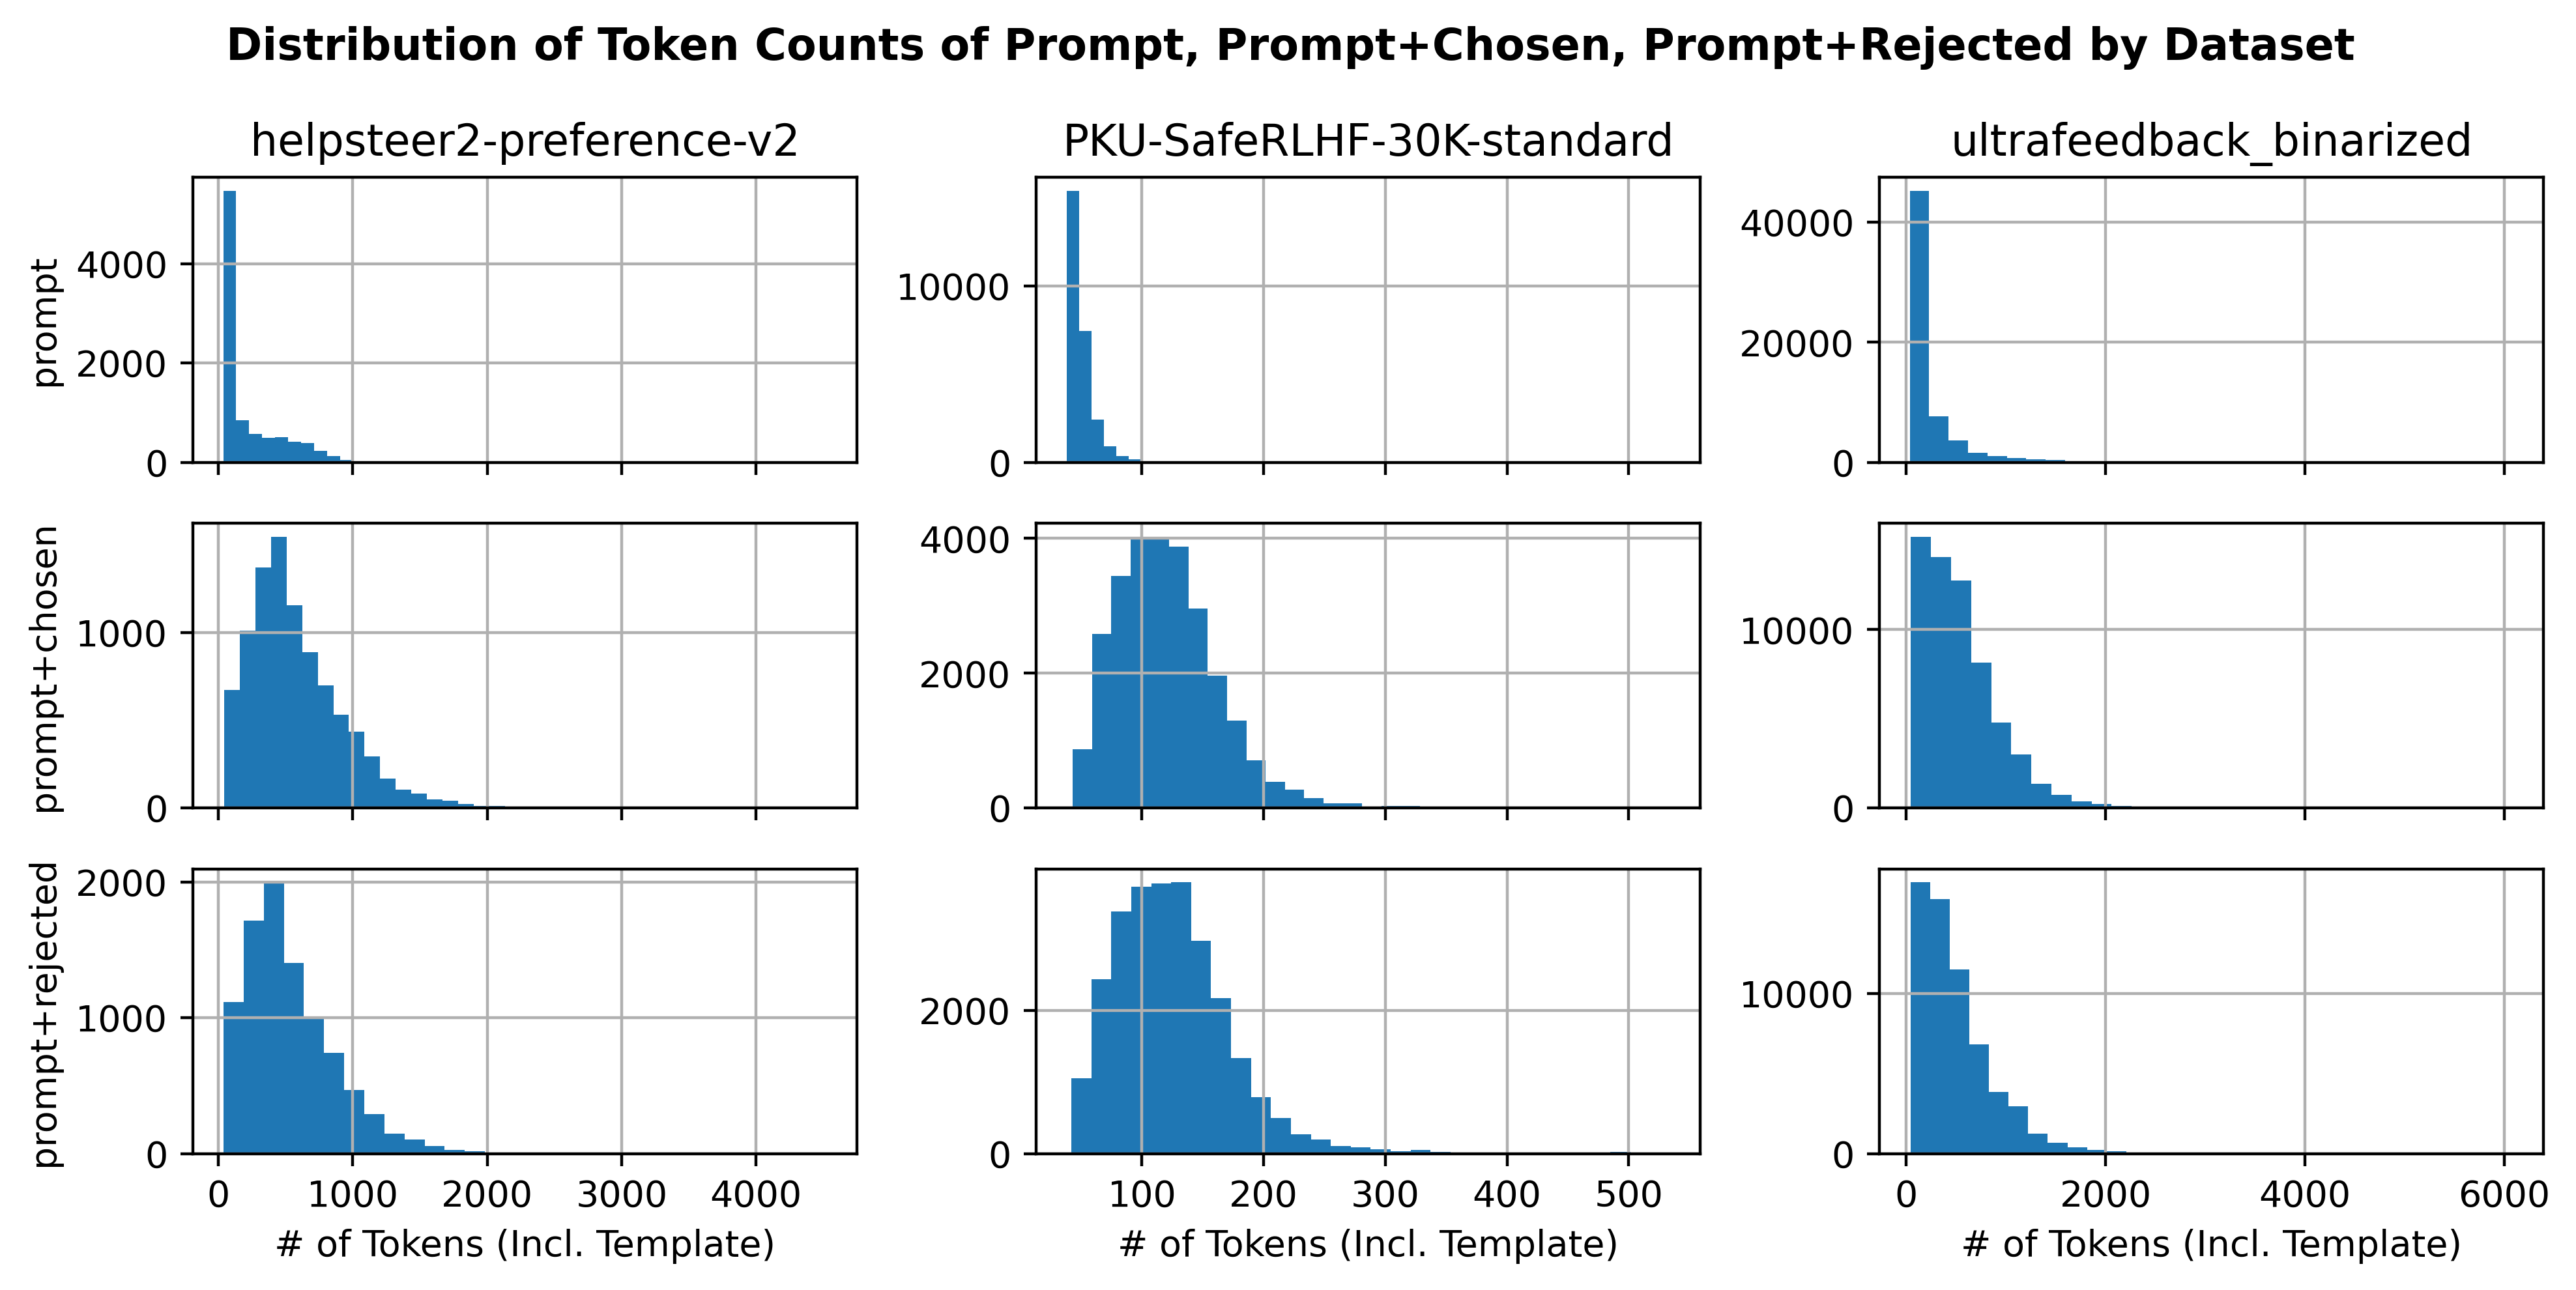

In [ ]:
# get a histogram of all three datasets
fig, ax = plt.subplots(3, 3, dpi=400, figsize=(10, 5), sharex="col")

# go thru all datasets + all of our variables of interest
for j, DATASET in enumerate(summary_dfs.keys()):
    for i, VAR in enumerate(["L_prompt_wc", "L_prompt+chosen_wc", "L_prompt+rejected_wc"]):

        # plot a histogram
        ax[i, j].hist(summary_dfs[DATASET][VAR].replace(np.inf, np.nan), bins=30)
        ax[i, j].grid()

        # selectively label
        if i == 0:
            ax[i, j].set_title(DATASET)
        if j == 0:
            ax[i, j].set_ylabel(
                {"L_prompt_wc" : "prompt",
                 "L_prompt+chosen_wc" : "prompt+chosen",
                 "L_prompt+rejected_wc" : "prompt+rejected"}[VAR])
        if i == 2:
            ax[i, j].set_xlabel("# of Tokens (Incl. Template)")

# beautify at the end
plt.suptitle(
    "Distribution of Token Counts of Prompt, Prompt+Chosen, Prompt+Rejected by Dataset", fontweight="bold")
plt.tight_layout()
plt.show()

In [ ]:
# set a seed for reproducibility
np.random.seed(858)

# figure out which datapoints I want to subsample -- need prompt as short as possible, but > 2.5th percentile
for DATASET in DATASETS_CLEANED:

    # get the dataframe of interest
    df_dataset = summary_dfs[DATASET].copy()

    # let's disqualify all rows below the 2.5th percentile on prompt length L
    L_prompt_cutoff = df_dataset.L_prompt_wc.quantile(0.025)
    df_dataset = df_dataset.query(f"L_prompt_wc > {L_prompt_cutoff}")

    # let's also np.inf out the rows that are in the 2.5th percentile on chosen + rejected (after this cut!)
    df_dataset["L_chosen_wc"] = df_dataset["L_prompt+chosen_wc"] - df_dataset["L_prompt_wc"]
    df_dataset["L_rejected_wc"] = df_dataset["L_prompt+rejected_wc"] - df_dataset["L_prompt_wc"]

    # see how many rows we are left with after applying the two more 2.5th percentile cuts
    L_chosen_cutoff = df_dataset.L_chosen_wc.quantile(0.025)
    L_rejected_cutoff = df_dataset.L_rejected_wc.quantile(0.025)
    df_dataset = df_dataset.query(f"L_chosen_wc > {L_chosen_cutoff} and L_rejected_wc > {L_rejected_cutoff}")

    # check how many remaining examples require less than 1024 tokens (worst-case!)
    df_dataset = df_dataset.query("`L_prompt+chosen_wc` <= 1024 and `L_prompt+rejected_wc` <= 1024")

    # status update
    print(f"Dataset: {DATASET}; Qualified Examples: {len(df_dataset.index)}.")

    # indices that we will use in our train, test, split
    indices = np.random.choice(a=df_dataset.index, size=7000, replace=False)

    # load in the original data, extract selected indices, random sample into 5K/1K/1K train-val-test splits
    df_examples = pd.read_csv(f"{DATASET_DIR}/{DATASET}_all-train-cleaned.csv")

    # get our train, val, test splits
    train_data = df_examples.loc[indices[:5000]]
    val_data = df_examples.loc[indices[5000:6000]]
    test_data = df_examples.loc[indices[6000:]]

    # save to .csv
    train_data.to_csv(f"{DATASET_DIR}/{DATASET}_train.csv")
    val_data.to_csv(f"{DATASET_DIR}/{DATASET}_val.csv")
    test_data.to_csv(f"{DATASET_DIR}/{DATASET}_test.csv")